<a href="https://colab.research.google.com/github/Sujith-the-great/My_Comp_Code/blob/master/Sujith_SML_Final_Project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pycocotools requests tqdm

In [2]:
import json
from pycocotools.coco import COCO
import requests
import os
from tqdm import tqdm

# Specify paths - adjust these accordingly
data_dir = '/content'
annotation_file = f'{data_dir}/annotations/captions_train2017.json'
ann_url = f"http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Download annotation zip file (for both train and val splits)
print(f"Downloading annotations...")
response = requests.get(ann_url, stream=True)
response.raise_for_status()

#total_downloaded = 0
with open(os.path.join(data_dir, "annotations_trainval2017.zip"), 'wb') as f:
  for chunk in tqdm(response.iter_content(1024), desc="Downloading annotations.zip"):
    f.write(chunk)
    #total_downloaded += len(chunk)
    #if total_downloaded >= num_images * 1024:
    #  break


In [3]:
!unzip -q annotations_trainval2017.zip -d {data_dir}

In [4]:
# Initialize the COCO API
coco = COCO(annotation_file)


# Get all image IDs
img_ids = coco.getImgIds()

# Get information for all images
img_data = coco.loadImgs(img_ids)

# Function to download an image
def download_image(image_id):
    img = coco.loadImgs(image_id)[0]
    url = img['coco_url']
    response = requests.get(url)

    # Assuming you have a folder called 'images'
    file_path = f'/content/images/image_{image_id}.jpg'
    with open(file_path, 'wb') as f:
        f.write(response.content)

# Collect the captions and download the images
images = []
texts = []

for img in img_data:
    image_id = img['id']
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    captions = [ann['caption'] for ann in anns]
    texts.append(captions)
    images.append(img['file_name'])

    # Optional: Download the image
    # download_image(image_id)

print(images)
print(texts)


loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
print(len(images))
print(len(texts))

118287
118287


In [6]:
print(images[200])
input_texts=[]
for text in texts:
   for t in text:
     input_texts.append(t)
print(len(input_texts))


000000121041.jpg
591753


In [7]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


In [8]:
class Generator(nn.Module):
    def __init__(self, embed_dim: int = 512):
        super().__init__()
        self.blocks = torch.nn.ModuleList().to('cuda')
        for i in range(embed_dim):
          self.blocks.append(nn.Linear(embed_dim, 16))
        self.qgelu = QuickGELU()
        self.transformer = Transformer(width=16, layers=3, heads=8)
        self.conv1 = nn.Conv2d(1, 3, kernel_size=(1,32), stride=(1,32))
        self.upsample = nn.Upsample(scale_factor=14)
        self.conv2 = nn.Conv2d(3,3, kernel_size=191, stride=1, padding=95)
        self.relu1 = nn.ReLU()
        self.conv3 = nn.Conv2d(3,3, kernel_size=95, stride=1, padding=47)
        self.relu2 = nn.ReLU()
        self.conv4 = nn.Conv2d(3,3, kernel_size=47, stride=1, padding=23)
        self.relu3 = nn.ReLU()
        self.conv5 = nn.Conv2d(3,3, kernel_size=23, stride=1, padding=11)
        self.relu4 = nn.ReLU()
        self.conv6 = nn.Conv2d(3,3, kernel_size=11, stride=1, padding=5)
        self.relu5 = nn.ReLU()
        self.conv7 = nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=2)
        self.relu6 = nn.ReLU()


    def forward(self, x: torch.Tensor):
        identity = x
        y = x
        z = torch.empty(0, device='cuda')   # Initialize an empty tensor on the GPU

        for block in self.blocks:
          block_output = block(y).to('cuda')  # Ensure block output is also on 'cuda'
          z = torch.cat([z, block_output.reshape(block_output.shape[0],1,block_output.shape[1])], dim=1)
        x = self.qgelu(z)
        x = self.transformer(x)
        x = x.permute(0,2,1)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.relu2(self.conv6(self.relu1(x)))
        # x = self.relu3(self.conv4(x))
        # x = self.relu6(self.conv7(self.relu5(self.conv6(self.relu4(self.conv5(x))))))
        return x

In [9]:
! pip install ftfy regex tqdm
! git clone https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.0 MB/s eta 0:00:00
Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 40.44 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [10]:
import sys
sys.path.append('/content/CLIP')
from clip import clip
import numpy as np

In [11]:
model, preprocess = clip.load("ViT-B/32")
if torch.cuda.is_available():
  model.cuda().eval()
else:
  model.cpu().eval()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
#print("state_dict : ", state_dict)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 69.9MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [12]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7e5f93323250>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [13]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [14]:
input_texts=[]

for text in texts:
  for t in text:
    input_texts.append(t)

text_tokens = clip.tokenize(input_texts).cuda()


In [15]:
print(text_tokens.shape)
"""
with torch.no_grad():
  text_features = model.encode_text(text_tokens).float()
"""

torch.Size([591753, 77])


'\nwith torch.no_grad():\n  text_features = model.encode_text(text_tokens).float()\n'

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
import torch
import torch.nn as nn
# ... Assume you have CLIP (model), Generator, and other components defined

def train_with_batches(model, generator, text_tokens, num_epochs=1000, batch_size=32, device="cuda"):
    model.eval()
    generator.train()

    num_batches = len(text_tokens) // batch_size
    optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        if os.path.isfile("generator_model.pth"):
          loaded_state_dict = torch.load("/content/generator_model.pth")
          generator.load_state_dict(loaded_state_dict)
        elif os.path.isfile("/content/gdrive/MyDrive/Colab Notebooks/generator_model.pth"):
          loaded_state_dict = torch.load("/content/gdrive/MyDrive/Colab Notebooks/generator_model.pth")
          generator.load_state_dict(loaded_state_dict)
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size

            text_batch = text_tokens[start_idx:end_idx].to(device)

            with torch.no_grad():
                text_embeddings = model.encode_text(text_batch).float()


            generated_images = generator(text_embeddings.cuda())
            image_embeddings = model.encode_image(generated_images)

            #image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
            #text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

            loss = ((image_embeddings-text_embeddings)**2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {i+1}/{num_batches}, Loss: {loss.item():.4f}')
        model_state_dict = generator.state_dict()
        torch.save(model_state_dict, "generator_model.pth")
        model_path = "/content/gdrive/MyDrive/Colab Notebooks/generator_model.pth"
        torch.save(model_state_dict, model_path)

# -------- Example Usage --------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    generator = Generator(embed_dim=512)  # Initialize your Generator model
    generator.to(device)

    train_with_batches(model, generator, text_tokens[0:19200], batch_size=64, device=device)


Epoch: 1/1000, Batch: 1/300, Loss: 0.0858


KeyboardInterrupt: 

torch.Size([1, 3, 224, 224])
torch.Size([224, 224, 3])


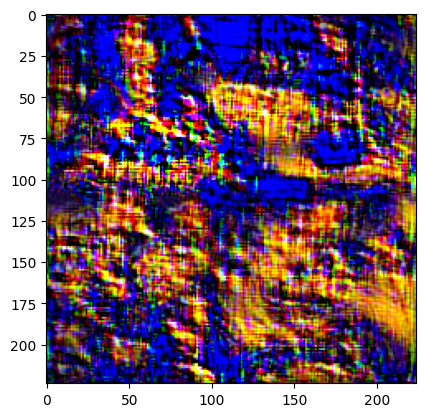

In [18]:
def generate_image(text):
  text_embedding = model.encode_text(clip.tokenize(text).cuda())
  generated_image = generator(text_embedding.float())
  return generated_image

import matplotlib.pyplot as plt
gen_img = generate_image("Blue Sky")
print(gen_img.shape)
gen_img = gen_img.reshape(gen_img.shape[1],gen_img.shape[2],gen_img.shape[3]).permute(1,2,0)
print(gen_img.shape)
plt.imshow(gen_img.detach().cpu())

In [21]:
test_texts = input_texts[19200:25600]
txt_embed = model.encode_text(clip.tokenize(texts[0][0]).cuda()).float()
gen_img_embed = model.encode_image(generator(model.encode_text(clip.tokenize(texts[0][0]).cuda()).float()))
#print(txt_embed-gen_img_embed)
print("Test Dataset Error :",((gen_img_embed-txt_embed)**2).mean().item())

Test Dataset Error : 0.06050895154476166
